# Graph matching for conformations

In [1]:
import numpy as np
import pandas as pd
import networkx as nx 
from scipy.cluster.hierarchy import linkage # fcluster, to_tree, dendrogram, 
from scipy.stats import pearsonr
import re
import scipy as sp 
import seaborn as sns
import copy
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multitest import fdrcorrection

In [2]:
from module.PGMD import SSE_read, pair_PGMD
from module.DME import DMatchEval
from module.sse_matching_master_draft import invd_sim_func, forward_chain_adj_prep, get_contact_matrix, draw_overlap_from_outputs, full_diff_matrix_figure

from module.cluster_utils import dendrogram_clustering


/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/graspologic/layouts/colors.py:13: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
/Users/ssm47/opt/anaconda3/envs/thesis_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
save_things=False

# data

In [4]:
# from full scop database:
fpath = '../../data/proteins/scop-cla-latest.txt'

with open(fpath) as f:
    lines = f.readlines()

headers = lines[5].strip('#').strip('\n').split(' ')[1:]

scop_df = pd.DataFrame([l.strip('\n').split(' ') for l in lines[6:]], columns=headers)



In [5]:
scopcla_col = [eval('dict(' + i + ')') for i in scop_df.SCOPCLA.values]
scopcla_df = pd.DataFrame(scopcla_col)
name_key = dict(TP='type', CL='class', CF='fold', SF='superfamily', FA='family')

TP=protein type, CL=protein class, CF=fold, SF=superfamily, FA=family

- **type**: four groups; soluble, membrane, fibrous and intrinsically disordered.
- **class**: 5 structural classes; all-alpha and all-beta proteins, containing predominantly alpha-helices and beta-strands, respectively, and ‘mixed’ alpha and beta classes (a/b) and (a+b) with respectively alternating and segregated alphahelices and beta-strands, and the fifth class of small proteins with little or no secondary structures. 
- **family**: closely related proteins with a clear evidence for their evolutionary origin.
- **superfamily**: groups together more distantly related protein domains.
- **fold**: global structural features shared by the majority of consitutent superfamily members. Some families with same superfamily can belong to different folds. 




In [6]:
scop_df['FA-PDBREG_a'] = scop_df['FA-PDBREG'].str.split(':').apply(lambda x:x[0])
scop_df['p_id'] = scop_df['FA-PDBID'].str.lower() +'_' + scop_df['FA-PDBREG_a'] 
scopcla_df['p_id'] = scop_df['p_id']
class_sample = scopcla_df.groupby('CL').sample(random_state=0)
sample_pid = class_sample.p_id.values

In [7]:
# # known pairs
# fpath = './data/sec_network/pairs.txt'
# known_pairs = pd.read_csv(fpath,delimiter = "\t").to_numpy()

In [8]:
# domain ranges:
fpath = '../../data/proteins/scop_sse_range.txt'
scop_ranges = pd.read_csv(fpath, delimiter='\t', header=None)
scop_ranges.columns = ['d_id', 'p_id', 'idx_range']
scop_ranges.d_id = scop_ranges.d_id.astype(str)

# filtered domains:
fpath = '../../data/proteins/filter_scop.txt'
scop_rf = pd.read_csv(fpath, delimiter='\t', header=None)
scop_rf.columns = ['p_id', 'seq']

# filtered SCOP proteins
rfiltered_pids = scop_rf.p_id.values


# redundancy filtered scop data frame
scop_rf_df = scop_df[scop_df['p_id'].isin(rfiltered_pids)]

rf_p_ids = list(set(scop_ranges.p_id) & set(scop_rf.p_id)) # proteins in both redundancy filtered and scop index range files (from Runfeng)...!

# SCOP FA/SF associated with proteins in redundancy filtered and has domain ranges available...
scopcla_df_rf = scopcla_df.query('p_id.isin(@rf_p_ids)')

In [9]:
rf_p_ids = sorted(scopcla_df_rf.p_id.unique())

In [10]:
(((((len(rf_p_ids)*len(rf_p_ids)-1)/2)*0.1)/3600)/12)/76 # number of arrays of 76 cores of 12 hour runs needed for an all by all comparison.

8.898111339546785

In [11]:
# trials = []
# for i in range(len(rf_p_ids)):
#     for j in range(i+1, len(rf_p_ids)):
#         trials.append([rf_p_ids[i], rf_p_ids[j]])
    


In [12]:
def condensed_index_to_ij(k, N):
    # Solve for i using the inverse of the triangular number formula
    i = int(np.floor(N - 2 - np.floor(np.sqrt(-8*k + 4*N*(N-1) - 7) / 2.0 - 0.5)))
    # Compute j from k and i
    j = int(k + i + 1 - N*(N-1)//2 + (N - i)*((N - i) - 1)//2)
    return i, j


N = len(rf_p_ids)
cdm_size = N*(N-1)/2



In [13]:
def condensed_indices_to_ij(k_array, N):
    k_array = np.asarray(k_array)

    # Inverse mapping from k to i (vectorized)
    i = np.floor(N - 2 - np.floor(np.sqrt(-8 * k_array + 4 * N * (N - 1) - 7) / 2.0 - 0.5)).astype(int)

    # Offset of row i in the condensed matrix
    offset = (N * i - i * (i + 1) // 2)

    # j can be directly computed
    j = (k_array - offset + i + 1).astype(int)

    inds = np.vstack([i, j]).T

    return inds

In [14]:
mltplr = np.ceil(cdm_size/(76*10)) 

m = 10
krange = [m*mltplr, min([(m+1)*mltplr, cdm_size])]
inds = condensed_indices_to_ij(k_array=np.arange(*krange), N=N)
idpairs = [(rf_p_ids[i[0]], rf_p_ids[i[1]]) for i in inds]

# krange = [m*mltplr, min([(m+1)*mltplr, cdm_size])]
# cid = [condensed_index_to_ij(k=i, N=N) for i in np.arange(*krange)]

## false positives in Runfeng's list:

In [15]:
fpath = '../../data/proteins/fp/exclusive_sse.txt'

false_positives = pd.read_csv(fpath, delimiter='\t', header=None, )
false_positives.columns =['id_1', 'id_2', 'tmscore']

fp_pairs= false_positives[['id_1', 'id_2']].values


In [16]:
path = '../../data/proteins/fp/ssnw'

eps = [] # sheet percentage coverage
sizes= []
for row in fp_pairs:
    id_1 = row[0]
    cmat, full_sses = get_contact_matrix(pid=id_1, dirpath=path)
    sse_count = Counter([i[0] for i in full_sses])
    hcount = sse_count['H']
    ecount = sse_count['E']
    e_percentage = ecount / (ecount+hcount)
    eps.append(e_percentage)
    sizes.append(len(cmat))

    

In [17]:
false_positives['id_1_size'] = sizes

In [18]:
false_positives.sort_values('id_1_size').iloc[50:100]

,id_1,id_2,tmscore,id_1_size
726,5h7c_A,6t46_G,0.280,19
1087,5h7c_C,6hc2_S,0.293,19
3142,5xbk_D,6hc2_C,0.474,19
16,5iof_B,6hc2_S,0.200,19
1333,5h7c_A,6hc2_U,0.301,19
3139,5xbk_D,5fg0_A,0.473,19
123,5iof_B,6t46_G,0.221,19
31,4oyf_F,5xah_D,0.209,19
647,5h7c_C,5a6c_B,0.276,19
1056,5h7c_A,5a6c_B,0.292,19


In [19]:
eps_series = pd.Series(eps) 

mixed_sh = eps_series[(eps_series > 0.4) & (eps_series < 0.6)].index.tolist()
sdom = eps_series[(eps_series > 0.6)].index.tolist() # sheet dominated
hdom = eps_series[(eps_series < 0.4)].index.tolist() # helix dominated

# All pairs in False Positives list:

In [20]:
# ssnw_path = '../../data/proteins/fp/ssnw'
# ssnw_fmt_path = '../../data/proteins/fp/ssnw_fmt'
# import glob
# fnames = glob.glob(ssnw_path + '/*')

# for fpath in fnames[:]:
#     data = pd.read_csv(fpath, delimiter = "\t")
#     samp = fpath.split('/')[-1][:-5]
    
#     savepath = ssnw_fmt_path + '/' + samp + '.txt'

#     cmat = data.iloc[1:, 2:].dropna(axis=0, how='all').dropna(axis=1, how='all')
#     lengths = data.Length[cmat.index.values].to_numpy()
#     ele_inds = data.iloc[:,1][cmat.index.values].to_numpy()
#     cmat.reset_index(drop=True, inplace=True)
#     cmat.columns = cmat.index.values    

#     new_indices = []
#     for ele, length in zip(ele_inds, lengths):
#         new_indices.append(ele[0] + str(int(length)))
#     cmat.insert(loc=0, column='ss_ele', value=new_indices)
#     cmat.replace(to_replace='-', value=np.inf, inplace=True)
#     full_lengths = data.Length[1:].to_list()
#     full_ssetypes = data.iloc[:,1][1:].to_list()
#     full_sses = []
#     for ele, length in zip(full_ssetypes, full_lengths):
#         full_sses.append(ele[0] + str(int(length)))
#     cmat.set_index('ss_ele', inplace=True)
#     cmat.replace(to_replace=np.inf, value='-', inplace=True)
#     cmat.reset_index(inplace=True)
#     cmat['extra'] = None

#     cmat.to_csv(savepath, sep='\t', mode='w', index = False)

In [21]:
chainval, alpha, gamma = 0.733152,	2.735147,	1.681227 
type_to_tex_dict = {'E':r'$\blacksquare$', 'H':r'$\bigcirc$'}
sdict = {'E':'s', 'H':'o'}

ssnw_path = '../../data/proteins/fp/ssnw_fmt'
o_path = '../../data/proteins/fp/orientation'

sse_inst = SSE_read(fpathprefix=ssnw_path, 
                    opathprefix=o_path, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=chainval, 
                    sim_func=invd_sim_func, 
                    chain_func=forward_chain_adj_prep)




pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 


In [22]:
len(fp_pairs)

3255

In [23]:
# dstats = []

# for id_1, id_2 in fp_pairs[:]:
#     sse_inst.reset_SSE()
#     pgmd_inst.refresh()
#     container = pgmd_inst.get_container(pids=[id_1, id_2],)
#     run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
#     layoutput = pgmd_inst.get_layoutput(seed=0)
#     perm_inds = run_gm_output['perm_inds']
#     ids = pgmd_inst.sorted_ids # sort the ids

#     cmat, orientation = sse_inst.set_pid(pid=ids[0]).prep_SSE()
#     adj_1 = cmat.replace([np.inf], 0).to_numpy()
#     sse_inst.reset_SSE()
#     cmat, orientation = sse_inst.set_pid(pid=ids[1]).prep_SSE()
#     adj_2 = cmat.replace([np.inf], 0).to_numpy()

#     diff = abs(adj_1 - adj_2[np.ix_(perm_inds, perm_inds)])

#     kstests = []
#     mwus = []
#     for i in range(1, diff.shape[1]-1):
#         block_1 = copy.deepcopy(diff[:i, :i])
#         non_diag_block_1 = block_1[~np.eye(block_1.shape[0], dtype=bool)]
#         block_2 = diff[i+1:, i+1:]
#         non_diag_block_2 = copy.deepcopy(block_2[~np.eye(block_2.shape[0], dtype=bool)])

#         off_diag_1 = copy.deepcopy(diff[:i, i+1:])
#         off_diag_2 = copy.deepcopy(diff[i+1:, :i])
#         within_block = np.hstack([non_diag_block_1.flatten(), non_diag_block_2.flatten()])

#         outof_block = np.hstack([off_diag_1.flatten(), off_diag_2.flatten()])

#         mwu = sp.stats.mannwhitneyu(within_block, outof_block, alternative='less')
#         mwus.append(mwu[1])

#     dstats.append({'id_1':id_1, 'id_2':id_2,'fnorm': layoutput['fnorm'], \
#                  'graph_edit_distance':layoutput['graph_edit_distance'], \
#                  'euclidean_distance': layoutput['euclidean_distance'], \
#                     'perm_inds': perm_inds, 'id_order':ids,  'mwutests':mwus})





# fp_gm_df = pd.DataFrame(dstats)
# fp_gm_df.to_parquet(f'../../data/proteins/processed/false_positives.parquet')

In [24]:
fp_gm_df = pd.read_parquet(f'../../data/proteins/processed/false_positives.parquet')

In [25]:
min_values = [min(j) for j in fp_gm_df.mwutests.values]
argmins = [np.argmin(j)+2 for j in fp_gm_df.mwutests.values]

bhcorr_values = [multipletests(j, method='fdr_bh', alpha=0.05)[:2] for j in fp_gm_df.mwutests.values]

bhcorr_minvalues = [min(multipletests(j, method='fdr_bh', alpha=0.05)[1]) for j in fp_gm_df.mwutests.values]
bhcorr_argmins = [np.argmin(multipletests(j, method='fdr_bh', alpha=0.05)[1])+2 for j in fp_gm_df.mwutests.values]

In [26]:
sum([not any(i[0]) for i in bhcorr_values])

159

In [27]:
fp_gm_df['bhcorr_minvalues'] = bhcorr_minvalues
fp_gm_df['bhcorr_argmins'] = bhcorr_argmins

fp_gm_df['minvalues'] = min_values
fp_gm_df['argmins'] = argmins

In [28]:
(fp_gm_df['bhcorr_minvalues'] < 0.001).sum() # number significant!

2790

In [29]:
(fp_gm_df['bhcorr_minvalues'] > 0.001).sum() # number insignificant!

465

In [30]:
# sample_pairs = fp_gm_df.sort_values('bhcorr_minvalues').reset_index(drop=True).iloc[np.floor(np.exp(np.linspace(0, np.log(len(fp_gm_df)), 5)))]

sample_pairs = fp_gm_df.sort_values('minvalues').reset_index(drop=True).iloc[[0, 30, 100, 200, 900]]

In [31]:
rank_bhadj_pvals = pd.DataFrame(fp_gm_df.sort_values('bhcorr_minvalues').reset_index(drop=True).bhcorr_minvalues.apply(np.log))


rank_pvals = pd.DataFrame(fp_gm_df.sort_values('minvalues').reset_index(drop=True).minvalues.apply(np.log10))

In [32]:
chainval, alpha, gamma = 0.733152,	2.735147,	1.681227 # 1.2 , 4.2, np.sqrt(2) # 2.371547,	7.207803,	0.784998 #   0.72020553, 3.52626461, 2.93014126 #  # 

type_to_tex_dict = {'E':r'$\blacksquare$', 'H':r'$\bigcirc$'}
sdict = {'E':'s', 'H':'o'}

ssnw_path = '../../data/proteins/fp/ssnw_fmt'
o_path = '../../data/proteins/fp/orientation'

# pairpathpf = f'./data/100_sec_map/sscm'
# pairopathpf = './data/100_sec_map/orientation'

sse_inst = SSE_read(fpathprefix=ssnw_path, 
                    opathprefix=o_path, 
                    fpathext='txt', 
                    opathext='txt', 
                    chainval=chainval, 
                    sim_func=invd_sim_func, 
                    chain_func=forward_chain_adj_prep)




pgmd_inst = pair_PGMD(assembly_func=sse_inst.assemble_strict) 


In [33]:
diffs = []
for id_1, id_2 in sample_pairs[['id_1', 'id_2']].to_numpy():
    sse_inst.reset_SSE()
    pgmd_inst.refresh()
    container = pgmd_inst.get_container(pids=[id_1, id_2],)
    run_gm_output = pgmd_inst.run_gm(pids=[id_1, id_2], alpha=alpha, gamma=gamma, use_lengths=True, match_args=None)
    # perm_inds = run_gm_output['perm_inds']
    # g2_to_g1_node_mapping = run_gm_output['node_mapping']
    # id_1, id_2 = pgmd_inst.sorted_ids # sort the ids
    layoutput = pgmd_inst.get_layoutput(seed=0)
    perm_inds = run_gm_output['perm_inds']
    ids = pgmd_inst.sorted_ids # sort the ids

    cmat, orientation = sse_inst.set_pid(pid=ids[0]).prep_SSE()
    adj_1 = cmat.replace([np.inf], 0).to_numpy()
    sse_inst.reset_SSE()
    cmat, orientation = sse_inst.set_pid(pid=ids[1]).prep_SSE()
    adj_2 = cmat.replace([np.inf], 0).to_numpy()

    diff = abs(adj_1 - adj_2[np.ix_(perm_inds, perm_inds)])
    diffs.append(diff)



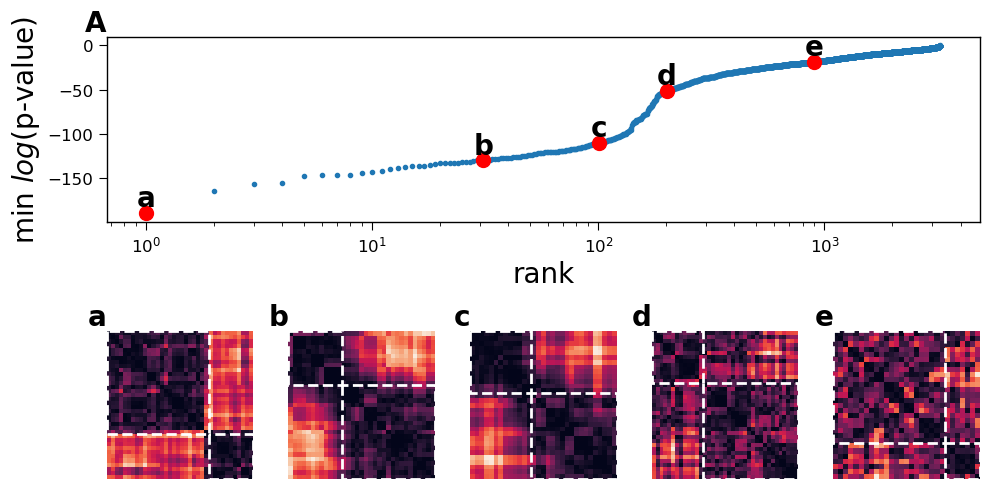

In [37]:

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2, 5, height_ratios=[5, 4])  # 2 rows, 2 columns

# axA = fig.add_subplot(gs[:, 0]) 
# axa = fig.add_subplot(gs[0, 1])  
# axb = fig.add_subplot(gs[1, 1])  
# axc = fig.add_subplot(gs[2, 1])  
# axd = fig.add_subplot(gs[3, 1])  
# axe = fig.add_subplot(gs[4, 1])  

axA = fig.add_subplot(gs[0, :]) 
axa = fig.add_subplot(gs[1, 0])  
axb = fig.add_subplot(gs[1, 1])  
axc = fig.add_subplot(gs[1, 2])  
axd = fig.add_subplot(gs[1, 3])  
axe = fig.add_subplot(gs[1, 4])  


# fp_gm_df.sort_values('bhcorr_minvalues').reset_index(drop=True).bhcorr_minvalues.apply(np.log).plot(marker='.')
axA.scatter(rank_pvals.index+1, rank_pvals.minvalues, marker='.')
axA.scatter(sample_pairs.index+1, sample_pairs.minvalues.apply(np.log10), marker='o', s=100, color='red')




labels = ['a', 'b', 'c', 'd', 'e']

for i in range(len(sample_pairs)):
    axA.text((sample_pairs.index.values+1)[i], sample_pairs.minvalues.apply(np.log10).values[i]+1, labels[i], ha='center', va='bottom',fontsize=20, fontweight='bold')

axA.text(0, 1, 'A', transform=axA.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
axA.set_xlabel('rank', size=20)
axA.set_ylabel(r'min $log(\text{p-value})$', size=20)
axA.set_xscale('log')
axA.tick_params(axis='both', labelsize=12,)  
axA.tick_params(axis='both', length=6, which='major')  
axA.tick_params(axis='both', length=3, which='minor')  

axA.spines['top'].set_linewidth(1)
axA.spines['bottom'].set_linewidth(1)
axA.spines['left'].set_linewidth(1)
axA.spines['right'].set_linewidth(1)

sub_axes = [axa, axb, axc, axd, axe]

for ax, label, hm, cutoff in zip(sub_axes, labels, diffs, sample_pairs.argmins.values):
    ax.text(0, 1, label, transform=ax.transAxes, fontsize=20, fontweight='bold', va='bottom',  ha='right')
    sns.heatmap(hm, ax=ax, cbar=False)
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.set_yticklabels([])
    ax.set_yticks([])

    diff_size = len(hm)
    # for cutoff, test in zip(cutoffs, testnames):
    corners = [(0, 0), (0, cutoff), (cutoff, cutoff), (cutoff, 0), ]  # (x, y) coordinates
    corners.append(corners[0])  # Close the box by repeating the first point
    polygon = patches.Polygon(corners, closed=True, edgecolor='white', facecolor='none', linewidth=2, linestyle='--')
    ax.add_patch(polygon)

    corners = [(cutoff, cutoff), (cutoff, diff_size), (diff_size, diff_size), (diff_size, cutoff)]  # (x, y) coordinates
    corners.append(corners[0])  # Close the box by repeating the first point
    polygon = patches.Polygon(corners, closed=True, edgecolor='white', facecolor='none', linewidth=2, linestyle='--')
    ax.add_patch(polygon)




plt.tight_layout()
# save_things=False
if save_things:
    plt.savefig(f'../figures/false_positives_conformations.png', dpi=300, bbox_inches='tight')
    plt.savefig(f'../figures/false_positives_conformations.pdf', dpi=300, bbox_inches='tight')

plt.show()

In [35]:


# bh_res = fdrcorrection(pvals=fp_gm_df.minvalues.values, alpha=0.05)

# b_res = multipletests(pvals=fp_gm_df.minvalues.values, method='bonferroni')

In [36]:
# fp_gm_df['sig'] = bh_res[0]
# fp_gm_df['sig'] = b_res[0]